In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
# 在实现过程中通常选择缩放点积注意力作为每一个注意力头。为了避免继续代价和参数代价的大幅增长，我们设定Pq=Pk=Pv=Po/h。值得注意的是，如果将查询、键和值的线性变换的纯输出数量设置为Pqh=Pkh=Pvh=Po，则可以并行计算h个头。在下面的视线中，Po是通过参数num_hiddens指定的。

In [21]:
class MultiHeadAttention(nn.Module):
    """多头注意力"""
    def __init__(self, key_size, query_size, value_size, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # queries, keys, values 的形状：
        # (batch_size, 查询或键值对的个数, num_hiddens)
        # valid_lens 的形状：
        # (batch_size), 或(batch_size, 查询的个数)
        # 经过变换之后，输出的queries, keys, values 的形状：
        # (batch_size*num_heads, 查询或者“键-值”对的个数， num_hidesns/num_heads)
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            # 在轴0，将第一项（标量或者矢量）复制num_heads次，然后如此复制第二项，然后诸如此类。
            valid_lens = torch.repeat_interleave(valid_lens, repeats=self.num_heads, dim=0)
        # output的形状：(batch_size*num_heads, 查询的个数，num_hiddens/num_heads)
        output = self.attention(queries, keys, values, valid_lens)
        d2l.show_heatmaps(
    output.cpu(),
    xlabel='Key positions', ylabel='Query positions')
        # output_concat的形状：(batch_size, 查询的个数，num_hiddens)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

In [22]:
# 为了能使多个头并行计算，上面的MultiHeadAttention类将使用下面定义的两个转置函数。具体来说，transpose_output函数反转了transpose_qkv函数的操作。

In [23]:
def transpose_qkv(X, num_heads):
    """为了多注意力头的并行计算而变换形状"""
    # 输入X的形状：(batch_size, 查询或者“键-值”对的个数, num_hiddens)
    # 输出X的形状：(batch_size, 查询或者“键值”对的个数, num_heads， num_hiddens/num_heads)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    #输出X的形状：(batch_size, num_heads, 查询或者“键-值”对的个数，num_hiddens/num_heads)
    X = X.permute(0, 2, 1, 3)

    # 最终输出X的形状：(batch_size*num_heads, 查询或者“键-值”对的个数，num_hiddens/num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])

def transpose_output(X, num_heads):
    """逆转transpose_qkv函数的操作"""
    # 输入X的形状：(batch_size*num_heads, 查询的个数，num_hiddens/num_heads)
    # 输出X的形状：(batch_size, num_heads, 查询的个数，num_hiddens/num_heads)
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    # 输出X的形状(batch_size, 查询的个数，num_heads, num_hiddens/num_heads)
    X = X.permute(0, 2, 1, 3)
    # 输出X的形状: (batch_size, 查询的个数， num_hiddens)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [24]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens, num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

TypeError: Invalid shape (20,) for image data

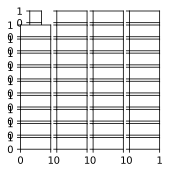

In [25]:
batch_size, num_queries = 2, 4
num_kvpairs, valid_lens = 6, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, valid_lens).shape

In [20]:
# 小结
# 多头注意力融合了来自于多个注意力汇聚的不同知识，这些只是的不同来源于相同的查询、键和值的不同的子空间表示。
# 基于适当的张量操作，可以实现多头注意力的并行计算。